## Project description:

Online shops have exact same items that are sold by multiple people. ML could help in order to group them.

In Kaggle competition [Shopee - Price Match Guarantee](https://www.kaggle.com/c/shopee-product-matching/overview) there are two item features provided: image and description.

Submission file has to include up to 50 best matches from train dataset for every test item.

Evaluation: mean F1

-----------

#### Planned approach in general

1. With pre-trained NLP model extract probabilities of described items
2. With pre-trained NN model extract probabilities of shown items
3. Build AND gate that include both models threshold

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch  # 1.4.0
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torchvision  # 0.5.0

import transformers  # 3.5.1
from transformers import AutoModel, BertTokenizerFast, AdamW

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from functools import partial

import time

import io
import os

RANDOM = 777

%load_ext nb_black

device = torch.device("cuda")

<IPython.core.display.Javascript object>

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

<IPython.core.display.Javascript object>

## EDA

**General info**

In [3]:
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


<IPython.core.display.Javascript object>

In [4]:
train_df.shape

(34250, 5)

<IPython.core.display.Javascript object>

In [5]:
test_df.head()

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


<IPython.core.display.Javascript object>

**Label distribution**

In [6]:
train_df.label_group.nunique()

11014

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='label_group'>

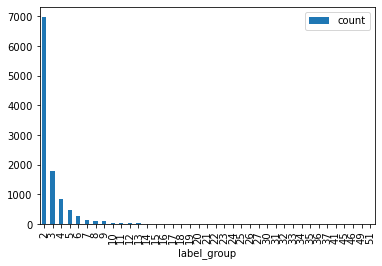

<IPython.core.display.Javascript object>

In [7]:
val_counts = train_df.label_group.value_counts()
value_df = pd.DataFrame(val_counts)
value_df["count"] = 1
value_df.groupby("label_group").sum().plot(kind="bar")

The vast majority of products have only 2 representatives of them in train dataset.

## NLP approach

**Preprocessing**

In [8]:
# extracting text and labels for train and test datasets
train_text = train_df.title.values
test_text = test_df.title.values
train_labels = train_df.label_group.values

<IPython.core.display.Javascript object>

In [9]:
# label encoding
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)

<IPython.core.display.Javascript object>

In [10]:
# balancing dataset
oversample = RandomOverSampler(sampling_strategy="not majority")
train_text, train_labels = oversample.fit_resample(
    train_text.reshape(-1, 1), train_labels
)

<IPython.core.display.Javascript object>

In [11]:
train_text = train_text.reshape(-1)

<IPython.core.display.Javascript object>

In [12]:
train_text, val_text, train_labels, val_labels = train_test_split(
    train_text, train_labels, random_state=RANDOM, test_size=0.5
)

<IPython.core.display.Javascript object>

**Modeling**

In [13]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained("bert-base-uncased")

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

<IPython.core.display.Javascript object>

<AxesSubplot:>

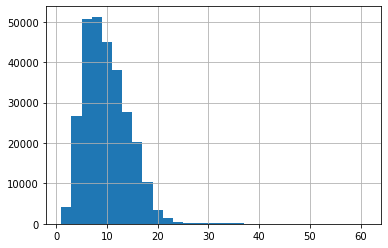

<IPython.core.display.Javascript object>

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins=30)

**20** is the optimal number for padding lenght, while majority of sentences fit into it.

In [15]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(), max_length=20, pad_to_max_length=True, truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(), max_length=20, pad_to_max_length=True, truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(), max_length=20, pad_to_max_length=True, truncation=True
)

C:\Users\ovidi\anaconda3\envs\berta\lib\site-packages\transformers\tokenization_utils_base.py:2016: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<IPython.core.display.Javascript object>

In [16]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])

<IPython.core.display.Javascript object>

In [17]:
# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

<IPython.core.display.Javascript object>

In [18]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

<IPython.core.display.Javascript object>

In [19]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, train_df.label_group.nunique())

        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):

        # pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

<IPython.core.display.Javascript object>

In [20]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

<IPython.core.display.Javascript object>

In [21]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

<IPython.core.display.Javascript object>

In [22]:
# defining loss metric
cross_entropy = nn.CrossEntropyLoss()

<IPython.core.display.Javascript object>

In [23]:
# function to train the model
def train():

    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # returns the loss and predictions
    return avg_loss, total_preds

<IPython.core.display.Javascript object>

In [24]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    return avg_loss, total_preds

<IPython.core.display.Javascript object>

In [25]:
epochs = 1

# set initial loss to infinite
best_valid_loss = float("inf")

# empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# for each epoch
for epoch in range(epochs):

    print("\n Epoch {:} / {:}".format(epoch + 1, epochs))

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "saved_weights.pt")

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"\nTraining Loss: {train_loss:.3f}")
    print(f"Validation Loss: {valid_loss:.3f}")


 Epoch 1 / 1
  Batch    50  of  8,777.
  Batch   100  of  8,777.
  Batch   150  of  8,777.
  Batch   200  of  8,777.
  Batch   250  of  8,777.
  Batch   300  of  8,777.
  Batch   350  of  8,777.
  Batch   400  of  8,777.
  Batch   450  of  8,777.
  Batch   500  of  8,777.
  Batch   550  of  8,777.
  Batch   600  of  8,777.
  Batch   650  of  8,777.
  Batch   700  of  8,777.
  Batch   750  of  8,777.
  Batch   800  of  8,777.
  Batch   850  of  8,777.
  Batch   900  of  8,777.
  Batch   950  of  8,777.
  Batch 1,000  of  8,777.
  Batch 1,050  of  8,777.
  Batch 1,100  of  8,777.
  Batch 1,150  of  8,777.
  Batch 1,200  of  8,777.
  Batch 1,250  of  8,777.
  Batch 1,300  of  8,777.
  Batch 1,350  of  8,777.
  Batch 1,400  of  8,777.
  Batch 1,450  of  8,777.
  Batch 1,500  of  8,777.
  Batch 1,550  of  8,777.
  Batch 1,600  of  8,777.
  Batch 1,650  of  8,777.
  Batch 1,700  of  8,777.
  Batch 1,750  of  8,777.
  Batch 1,800  of  8,777.
  Batch 1,850  of  8,777.
  Batch 1,900  of  8,777

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1409792 bytes. Buy new RAM!


<IPython.core.display.Javascript object>

In [ ]:
model()